In [62]:
import cmath
import matplotlib.pyplot as plt

# Spacecraft class. Only contains the external grid for now.
class Spacecraft:
    
    # Initialize the grid: the datatype is [x, y, color]
    def __init__(self):
        
        self.grid = [[0, 0, 1]]
        return
    
    # returns the grid, sometimes useful   
    def get_grid(self):
        
        return self.grid
    
    def get_grid_panel(self, x, y):
        
        panel = [item for item in self.grid if item[0]==x and item[1]==y][0]
        
        return panel
    
    
    def set_grid_panel_color(self, x, y, color):
        
        for item in self.grid:
            if item[0] == x and item[1] == y:
                item[2] = color
                break
                
        return
        
    # Get color of panel in position (x, y).
    # If not present in current map, add it to map with color 0 = black
    def get_color(self, x, y):
        
        for item in self.grid:
            if item[0] == x and item[1] == y:
                return item[2]
        
        self.grid.append([x, y, 0])
        return 0


# Class of the painting robot: probably would be better to make parent class robot and 
# child class for painting robot.
class Robot:
    
    def __init__(self):
        # Brain of the robot
        self.brain = IntcodeComputer()
        # No program installed yet
        self.paint_installed = False
        # Save the track of the robot
        self.track_record = [0]
        # Save the number of paints
        self.paint_count = 0
        # Start the robot facing up. We use complex number for the direction since rotation
        # is simply given by multiplication by using them. See later 'rotate_and_move()' funtion.
        self.facing = 1j
        # Keep track of the total covered area
        self.covered_area = 1
    
    # Use built-in IntcodeComputer 'load_intcode' function to load the intcode instructions
    # to the brain of the robot
    def load_software(self, software):
        
        self.brain.load_intcode(software)
        self.paint_installed = True
        
        return
    
    # Function that access the camera of the robot
    # Gets the color of the surface of the spacecraft at current position of the robot
    def camera(self, panel):
        
        # Current coordinates of robot 
        x = self.track_record[-1].real
        y = self.track_record[-1].imag
        color = panel.get_color(x, y)
        
        return color
    
    # Paint the surface at the current position with the given color
    # Makes use of 'set_grid_panel_color()' function of class Spacecraft
    def paint(self, color, surface):
        
        x = self.track_record[-1].real
        y = self.track_record[-1].imag
        
        surface.set_grid_panel_color(x, y, color)  
        # Increase the counter of paint operations
        self.paint_count += 1
        
        return
    
    # Move the robot according to the instruction
    def rotate_and_move(self, instruction):
        
        # Multiply by the imaginary unit 'i' ('j' in python) is equivalet to a rotation of 90 degrees in 
        # the counter-clockwise direction, and viceversa with -i
        if instruction == 0:
            self.facing *= 1j
        elif instruction == 1:
            self.facing *= -1j
        
        # Initialize new position. Again using complex numbers, this is really simple
        new_position = self.track_record[-1] + self.facing
        
        # If it is not in the positions already visited by the robot, increase the counter of the area
        if new_position not in self.track_record:
            self.covered_area += 1
        
        # Move to the new position   
        self.track_record.append(new_position)
        
        return
        
    
    # Single instruction of the robot: takes input from camera and returns color to paint
    # and next direction to move in
    def run_brain(self, camera_input):
                  
        second_output = None
        # First output
        first_output = self.brain.run(camera_input)
        
        # The Intcode computer returns -1 once it reaches an opcode 99 and halts.
        # Until then we must run again the computer to get the second output
        if first_output != -1:
            # Rotate instruction
            second_output = self.brain.run()
        
        return first_output, second_output
    
    # Whole painting program
    def run_paint_program(self, surface):
        
        # Remember to load the software to the robot before trying to call the program!
        if not self.paint_installed:
            
            print("ERROR: Missing software information, painting program was not found.")
            print("Usage: ")
            print("- load painting program with 'Robot.load_software(<PROGRAM_NAME>)'")
            print("- run with Robot.run_paint_program(<SPACECRAFT_NAME>)")
            return False
        
        
        hault = False
        while not hault:
            
            # Get color of current panel
            panel_color = self.camera(surface)
            # Call brain to get painting and moving instructions
            color_instr, move_instr = self.run_brain(panel_color)
            
            # until the intcode has haulted
            if color_instr != -1:
                
                # Paint current panel
                self.paint(color_instr, surface)
                # Move to next position
                self.rotate_and_move(move_instr)
                           
            else:
                hault = True
                
        return True
            
        
        
class IntcodeComputer:
    
    # Initialize parameters of the computer
    def __init__(self):
        self.position = 0
        self.intcode = []
        self.rel_base = 0
        return
    
    # Load the Intcode sequence instructions
    def load_intcode(self, intcode):
        self.intcode = intcode[:]
        return
    
    # Runtime function: checks if current instruction, which is still to be executed, 
    # will try to access memory addresses outside the current memory of the Intcode.
    # If this is the case, extend the Intcode sequence with zeros up until that memory address.
    # Since instruction can have different number of parameters and these can be in different
    # modes, the function cycle through the given instruction parameters and their mode, and for each
    # checks if it correspond to an out-of-bound address.
    def memcheck(self, inst):
        
        # Index of parameter. Starts from 1 because 0 is the opcode
        param_index = 1
        # Boolean variable. Has memory been extended?
        mem_ext = False
    
        # For each mode (and thus parameter, since these are one-to-one)
        for mode in inst.param_mode:
        
            # Try to access the corresponding element in immediate mode. This must be done
            # independently of the current mode, since position and relative modes still
            # needs to evaluate the immediate expression before their full evaluation.
            try:
                access = self.intcode[self.position+param_index]
                
            # Otherwise fill the intcode with zeros until that position
            except:
                mem_ext = True
                for i in range(len(self.intcode), self.position+param_index+1):
                    self.intcode.append(0)
        
            # Now, if mode is 0, check address interpreted in position mode
            if mode == 0:        
                try: 
                    access = self.intcode[self.intcode[self.position+param_index]]
                except:
                    mem_ext = True
                    for i in range(len(self.intcode), self.intcode[self.position+param_index]+1):
                        self.intcode.append(0)
            
            # If mode is 2, use relative mode
            elif mode == 2:
                try: 
                    access = self.intcode[self.intcode[self.position+param_index] + self.rel_base]
                except:
                    mem_ext = True
                    for i in range(len(self.intcode), self.intcode[self.position+param_index]+self.rel_base+1):
                        self.intcode.append(0)
            
            # Increment the index for next parameter
            param_index += 1

        return mem_ext
        
    
    # This is a useful function to avoid filling the code with if-else statements
    # It interprets the parameter with given offset wrt the current position (self.position)
    # in the given mode, and returns the corresponding intcode instruction.
    # In general, the value of a parameter of an instruction in the intcode program will
    # be given by: IntcodeSequence[address_wrapper(...)].
    def address_wrapper(self, mode, offset):
        
        # Position 
        if mode == 0:
            return self.intcode[self.position + offset]
        # Immediate
        elif mode == 1:
            return self.position+offset
        # Relative
        elif mode == 2:
            return self.intcode[self.position+offset] + self.rel_base
        
    
    # This function reads and initialize the first 2 parameters of an instruction, if the
    # instruction requires parameters at all. The third parameter is always a 'write'
    # parameter so we cannot initialize it inside here
    def init_read_param(self, inst):
        
        a, b = None, None
        
        if inst.n_params > 0:
            a = self.intcode[self.address_wrapper(inst.param_mode[0], 1)]
        
        if inst.n_params > 1:
            b = self.intcode[self.address_wrapper(inst.param_mode[1], 2)]
    
        return a, b
    
    
    # When the program is launched with 'debug = True' argument, 
    # after each instruction some information about the operation will be displayed
    def debug_info(self, inst, prev_intc, prev_pos):
        
        print('*** DEBUGGER ***')
        par = [prev_intc[x] for x in range(prev_pos, prev_pos + inst.increment)]
        print('Instruction: ', *par)
        print('Opcode: ', inst.opcode)
        print('Parameter modes: ', inst.param_mode)
        print('\n\n')
        
    
    # The function that run the Intcode program    
    def run(self, user_input = None, debug = False):
        
        i = Instruction(self.intcode[self.position])
        
        while(i.opcode != 99): 
            
            if debug == True:
                intc_backup = self.intcode[:]
                prev_pos = self.position
            
            if not i.is_corrupted:
            
                self.memcheck(i)
 
                # Initialize variables if needed for execution of the instruction
                read1, read2 = self.init_read_param(i)
   
                # Add
                if i.opcode == 1:
                
                    self.intcode[self.address_wrapper(i.param_mode[2], 3)] = read1 + read2
                    self.position += i.increment
            
                # Multiply
                elif i.opcode == 2:
                
                    self.intcode[self.address_wrapper(i.param_mode[2], 3)] = read1*read2
                    self.position += i.increment
                
                # Write input to address    
                elif i.opcode == 3:
                
                    if type(user_input) == type(1):
                        
                        self.intcode[self.address_wrapper(i.param_mode[0], 1)] = user_input
                          
                    else:
                        
                        print("ERROR: Missing user input.")
                        print("Usage: 'yourComputer.run(USER_INPUT)'")
                        return 0
                
                    self.position += i.increment
                
            
                # Print output from address
                elif i.opcode == 4:
                    
                    output = read1
                    self.position += i.increment
                    #print("Output: ", output, '\n')
                    return output
            
                # jump-if-True
                elif i.opcode == 5:
                    if read1 != 0:
                        self.position = read2
                    else:
                        self.position += i.increment
            
                # jump-if-false
                elif i.opcode == 6:
                    if read1 == 0:
                        self.position = read2
                    else:
                        self.position += i.increment
            
                # less-than
                elif i.opcode == 7:
                    
                    self.intcode[self.address_wrapper(i.param_mode[2], 3)] = 1 if read1 < read2 else 0
                    self.position += i.increment
            
                # equal
                elif i.opcode == 8:
                    
                    self.intcode[self.address_wrapper(i.param_mode[2], 3)] = 1 if read1 == read2 else 0
                    self.position += i.increment
        
                # adjust relative base
                elif i.opcode == 9:
                   
                    self.rel_base += self.intcode[self.address_wrapper(i.param_mode[0], 1)]
                    self.position += i.increment   
                
            # If opcode is unknown
            else:
                print("Unknown opcode '" + str(i.opcode) + "'. Terminating.")
                return -1
   
            if debug == True:
                self.debug_info(i, intc_backup, prev_pos)
            
            # Read the future instruction
            i = Instruction(self.intcode[self.position])
            #print(sequence)
     
        print("Program is finished. Haulting.")
    
        return -1


# A structured data type for instructions
class Instruction:
        
    def __init__(self, code):
        
        # Sets that associates an opcode with its associated number of parameters
        # 3 parameters opcodes
        III_params = [1, 2, 7, 8]
        # 2 parameters opcodes
        II_params = [5, 6]
        # 1 parameter opcodes
        I_params = [3, 4, 9]
        
        # Variables of the instruction set
        # Increment value after instruction
        self.increment = 0
        # Number of parameters
        self.n_params = 0
        # Parameter modes
        self.param_mode = []
        # Control variable
        self.is_corrupted = False
        # Number of digits that make up the opcode
        opcode_digits = 2
        
        lscode = list(str(code))
        self.opcode = int(''.join(lscode[-opcode_digits:])) # This works even if len(o) = 1!
        
        if self.opcode in III_params:
            self.increment = 4
            self.n_params = 3
            # My favorite line <3
            #self.param_mode = [int(x) if len(o) > 2 else 0 for x in reversed(o[:-2])]
        elif self.opcode in I_params:
            self.increment = 2
            self.n_params = 1
            
        elif self.opcode in II_params:
            self.increment = 3
            self.n_params = 2
       
        elif self.opcode == 99:
            pass
            
        else:
            self.is_corrupted = True
        
        # Intialize the modes of the parameters in the instruction, if it has any
        for i in range(self.n_params):
            # try to access mode information
            try:
                # Revert the lscode since the parameter modes appear last-to-first but we need the opposite
                rlscode = lscode[::-1]    
                self.param_mode.append(int(rlscode[opcode_digits + i]))
            # if there isn't any, mode is 0 (position) by default    
            except:
                self.param_mode.append(0)

In [63]:
# Load input
with open('input.txt', 'r') as infile:
    Intcode = infile.read().replace('\n', '').split(',')
    
Intcode = [int(x) for x in Intcode]

# For now the spacecraft consists only of the external surface
my_spacecraft = Spacecraft()

# Initialize my painting hull robot
painting_hull_robot = Robot()
# Load painting program
painting_hull_robot.load_software(Intcode)
# Run robot
painting_hull_robot.run_paint_program(my_spacecraft)

Program is finished. Haulting.


True

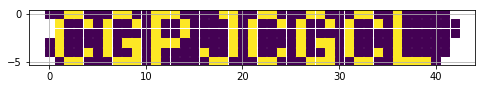

250


In [64]:
# This layout print the registration ID of part 2
plt.figure(figsize=(8, 1))

# get coordinates of panels and their final colors
x = [item[0] for item in my_spacecraft.grid]
y = [item[1] for item in my_spacecraft.grid]
col = [item[2] for item in my_spacecraft.grid]

plt.scatter(x, y, c = col, marker = 's', s = 70)
plt.grid()
plt.show()
print(len(x))

In [60]:
print("Total paintings: ", painting_hull_robot.paint_count)
print("Total position visited: ", painting_hull_robot.covered_area)
print("Solution to part 1 is either 'Total position visited' or that minus 1...")

Total paintings:  10491
Total position visited:  1876
Solution to part 1 is either 'Total position visited' or that minus 1...


### Part 2: The correct registration ID

To solve part 2 and get the ID, just change the __init__() function in Spacecraft Class to 

`
def __init__():
     self.grid = [[0, 0, 1]]
     return
`

This means that the starting point of the robot $(0, 0)$ is a $white$ panel. The rest of the code is unchanged.